In [244]:
Threads.nthreads()

16

In [245]:
using Plots
using DSP
using FFTW

In [246]:
include("radarsim.jl")
using .radarsim;

In [361]:
samp_rate = 5e6  #hz
prf = 100 #Hz
duty_factor = .15; #.05
β = 1e6; #Pulse Bandwidth
repetitions = 128;
fc = 900_000_000; #Hz

Gt = 40; #dB
Gr = 45; #dB
system_loss = 6; #dB

targets = [Target(360_094, 0), Target(900_000, 0)]
num_targets = length(targets);

In [362]:
τ = duty_factor * (1/prf);
λ = (1/fc) * c;

In [363]:
(1/prf * c / 2) / 1000 #Maximum Range KM

1498.96229

In [364]:
(τ * c / 2) / 1000 #Minimum Range KM

224.8443435

In [365]:
t, pulse_train = gen_pulse_train(repetitions, samp_rate, prf, τ, β);

In [366]:
rx_pulse_train = sim_return(samp_rate, pulse_train, targets, fc=fc, system_loss=system_loss, Gt=Gt, Gr=Gr, SNR=-24);

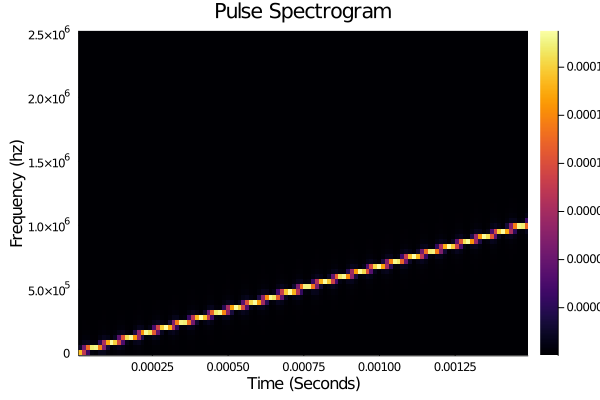

In [367]:
fft_size = 128;
spec = spectrogram(pulse_train[begin:round(Int, τ*samp_rate)], fft_size; fs=samp_rate); #+ pulse_train

heatmap(spec.time, LinRange(0,samp_rate/2, round(Int, fft_size/2)), spec.power[begin:round(Int, fft_size/2) , :], xguide="Time (Seconds)", yguide="Frequency (hz)", title="Pulse Spectrogram")

In [368]:
null, p = single_pulse(samp_rate, prf, τ, β);
pulse_compression = conv(rx_pulse_train, reverse(p[begin:round(Int, τ*samp_rate)]));

In [369]:
pulse_compression = pulse_compression[1:length(rx_pulse_train)];


In [370]:
len = Int(1/prf * samp_rate);
range_stacked = reshape(pulse_compression, len, repetitions);


In [371]:
#heatmap(abs.(range_stacked))

In [372]:
range_doppler = fft((range_stacked), (2,));

In [393]:
maxRange = ((1/prf * c)/2)
maxDop = (prf*λ)/4;

rangeLabel = LinRange(0, maxRange , 13);
dopplerLabel = LinRange(-maxDop,maxDop,13);

rangeLabel = round.(Int, (rangeLabel ./ 1000));
dopplerLabel = round.(dopplerLabel, digits=2);

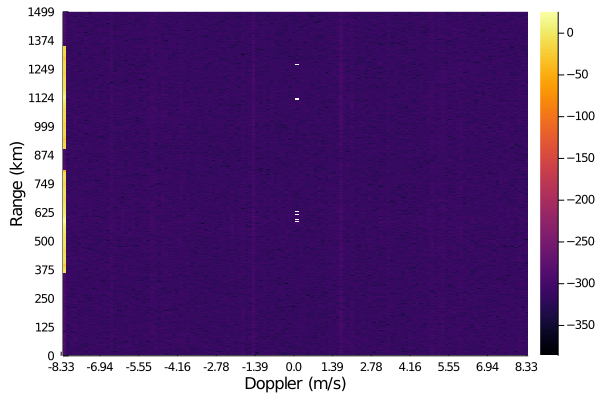

In [374]:
heatmap(20*log10.(abs.(range_doppler)), xlabel="Doppler (m/s)", ylabel="Range (km)", xticks=(LinRange(0,repetitions, 13), dopplerLabel), yticks=(LinRange(1,len,13), rangeLabel))

In [394]:
v = 0:(maxDop * 4);

r = ((c^2)/(8*fc)) ./ v;

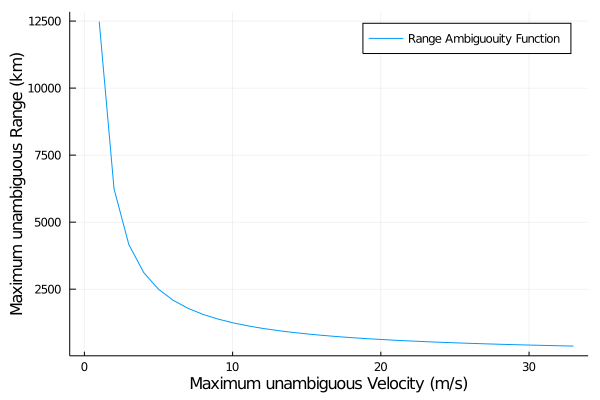

In [400]:
plot(v,r./1000, labels="Range Ambiguouity Function", xlabel="Maximum unambiguous Velocity (m/s)", ylabel="Maximum unambiguous Range (km)")